# Setup

## Dependencies

In [9]:
# Standard libraries imports
import os
import shutil
import random
from pathlib import Path
import sys

# Third-party libraries imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from PIL import Image
from huggingface_hub import hf_hub_download

# Local imports
from src.gradcam.gradcam_utils import pre_gradcam, gradcam, post_gradcam, gradcam_plus_plus
from src.gradcam.mil_gradcam_utils import pre_mil_gradcam, mil_gradcam, post_mil_gradcam
from src.gradcam.model_loader import load_full_model, load_full_mil_model


# GradCAM

In [10]:
def load_data_bbx3(data_folder: str) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Load and process dataset with bounding box annotations from metadata CSV.

    This function reads metadata containing bounding box annotations, processes
    them into structured formats, and splits the data into training and test sets.
    It automatically tries to load 'metadata2.csv' first, falling back to 'metadata.csv'
    if not found.

    Parameters
    ----------
    data_folder : str
        Path to the folder containing the metadata CSV file.
        The folder should contain either 'metadata2.csv' or 'metadata.csv'.

    Returns
    -------
    train_df : pandas.DataFrame
        Training dataset with the following columns:

        - image_id : str or int
            Unique identifier for each image.
        - x, y, width, height : numeric
            Individual bounding box coordinates and dimensions.
        - split : str
            Dataset split identifier (value: "train").
        - bbx : list of numeric
            Single bounding box as [x, y, width, height].
        - bbx_list : list of list
            All bounding boxes for the same image_id, aggregated as
            [[x1, y1, w1, h1], [x2, y2, w2, h2], ...].
        - Additional columns from the original CSV as available.

    test_df : pandas.DataFrame
        Test dataset with the same column structure as train_df, but filtered
        for split == "test".

    Notes
    -----
    - The function prioritizes 'metadata2.csv' over 'metadata.csv'.
    - Each row in the original CSV represents one bounding box annotation.
    - The 'bbx' column contains individual box coordinates as a list.
    - The 'bbx_list' column aggregates all boxes belonging to the same image_id,
      enabling easy access to multi-object annotations.
    - Images with multiple objects will have multiple rows with the same image_id
      but different bounding box coordinates.
    - The split column must contain 'train' and 'test' values to partition the data.

    Examples
    --------
    >>> train_df, test_df = load_data_bbx3('data/annotations/')
    >>> print(f"Train samples: {len(train_df)}, Test samples: {len(test_df)}")
    Train samples: 1250, Test samples: 350

    >>> # Access bounding boxes for a specific image
    >>> image_boxes = train_df[train_df['image_id'] == 'img_001']['bbx_list'].iloc[0]
    >>> print(f"Image has {len(image_boxes)} objects")
    Image has 3 objects

    >>> # Each bounding box format
    >>> single_box = train_df.iloc[0]['bbx']
    >>> print(f"Bounding box: x={single_box[0]}, y={single_box[1]}, "
    ...       f"w={single_box[2]}, h={single_box[3]}")
    Bounding box: x=150, y=200, w=100, h=120

    >>> # Get all boxes for visualization
    >>> for idx, row in train_df.iterrows():
    ...     image_id = row['image_id']
    ...     all_boxes = row['bbx_list']  # List of all boxes for this image
    ...     # Draw boxes using post_gradcam or other visualization tools
    """
    metadata_path = os.path.join(data_folder, "metadata2.csv")
    if not os.path.exists(metadata_path):
        metadata_path = os.path.join(data_folder, "metadata.csv")

    df = pd.read_csv(metadata_path)

    # Create bbx column from x, y, width, height columns
    df["bbx"] = df[["x", "y", "width", "height"]].apply(
        lambda row: [row["x"], row["y"], row["width"], row["height"]], axis=1
    )

    # Group all bounding boxes by image_id into a list
    bbx_grouped = df.groupby("image_id")["bbx"].apply(list).reset_index().rename(columns={"bbx": "bbx_list"})
    df = df.merge(bbx_grouped, on="image_id", how="left")

    # Split into train and test sets
    train_df = df[df["split"] == "train"]
    test_df = df[df["split"] == "test"]

    return train_df, test_df

## Standard

In [16]:
# thử nghiệm với ảnh thứ 21
dataset_folder = './Copyof_SGM1000bbx_results/SGM1000bbx_V2/SGM1000bbx'
train_df, test_df = load_data_bbx3(dataset_folder)
test_df.iloc[21]

ID                                                              2311011046
image_id                                   2311011046_20231222_MLO_L_0.png
img_width                                                              689
img_height                                                            1755
x                                                                    173.0
y                                                                    976.0
width                                                                280.0
height                                                               240.0
birads                                                                 7.0
lesion                                                                mass
abnormality                                                       positive
pathology_cu                                                     malignant
three_classes                                                    malignant
age                      

In [20]:
# Create full model nhớ đường link full model

dataset_folder = './Copyof_SGM1000bbx_results/SGM1000bbx_V2/SGM1000bbx'
model_link = '/home/mtoan65/AI/BioMedAI/Mammo_2025_Proj/mammoSGM/SGM1000bbx_448x448_based_resnet50_8188.pth'
reports_link = './'

!python -m src.trainer.train_based \
    --mode gradcam \
    --batch_size 16 \
    --config config.yaml \
    --data_folder $dataset_folder \
    --model_type resnet50 \
    --pretrained_model_path $model_link \
    --output $reports_link

=== Dataset Statistics ===
Total samples: 3831
  - Train: 3031 (79.1%)
  - Test:  800 (20.9%)
Unique patients (train): 799
Unique patients (test):  200

Label distribution (cancer):
Label | Train  | Test | Total  | % of total
  0   |  1964   |  516  |  2480   |  64.7%
  1   |  1067   |  284  |  1351   |  35.3%
Loaded pretrained model from /home/mtoan65/AI/BioMedAI/Mammo_2025_Proj/mammoSGM/SGM1000bbx_448x448_based_resnet50_8188.pth
Saved full model and info for GradCAM to /home/mtoan65/AI/BioMedAI/Mammo_2025_Proj/mammoSGM/SGM1000bbx_448x448_based_resnet50_8188_full.pth
Model info:
  input_size: (448, 448)
  gradcam_layer: layer4
  model_name: ResNet
  normalize: {'mean': [0.5, 0.5, 0.5], 'std': [0.5, 0.5, 0.5]}
  inference_time: 0.15550017356872559


Checkpoint: dict_keys(['model', 'input_size', 'gradcam_layer', 'model_name', 'normalize', 'inference_time'])


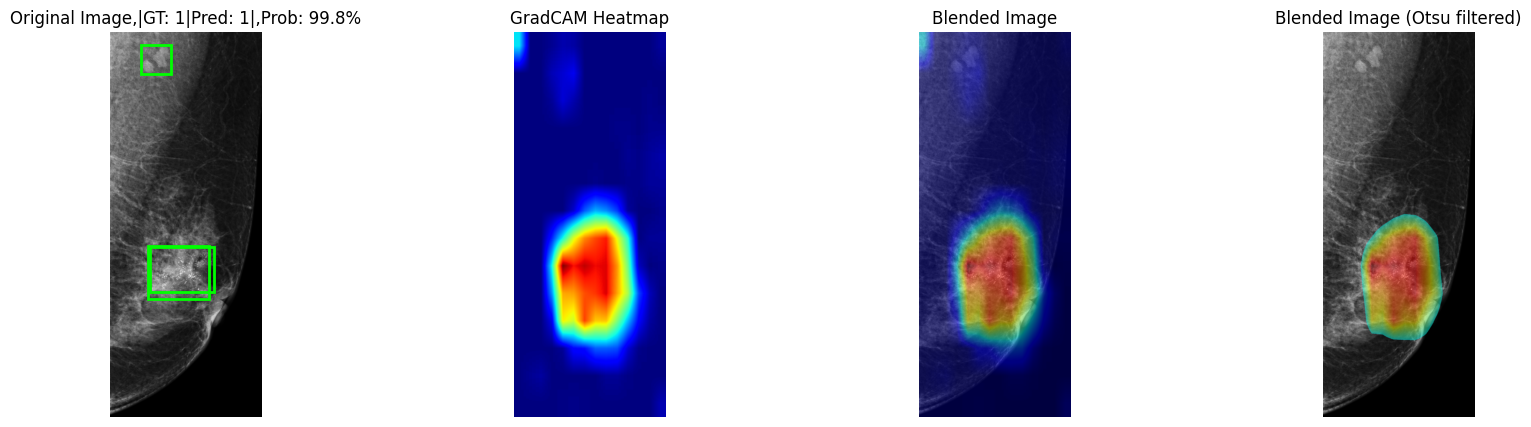

In [21]:
# Example usage
dataset_folder = './Copyof_SGM1000bbx_results/SGM1000bbx_V2/SGM1000bbx'
train_df, test_df = load_data_bbx3(dataset_folder)
pretrained_model_path = '/home/mtoan65/AI/BioMedAI/Mammo_2025_Proj/mammoSGM/SGM1000bbx_448x448_based_resnet50_8188_full.pth'

model_tuple = load_full_model(pretrained_model_path)

image_path = os.path.join(dataset_folder, test_df.iloc[21]['link'])
bbx_list = test_df.iloc[21]['bbx_list']
gt = test_df.iloc[21]['cancer']

model, input_tensor, img, target_layer, class_idx, pred_class, prob_class = pre_gradcam(model_tuple, image_path, target_layer=None, class_idx=None)
gradcam_map = gradcam(model, input_tensor, target_layer, class_idx)
#gradcam_map = gradcam_plus_plus(model, input_tensor, target_layer, class_idx)
post_gradcam(gradcam_map, img, bbx_list=bbx_list, option=5, blend_alpha=0.5, pred=pred_class, prob=prob_class, gt_label=gt)


In [6]:
# # Example usage
# dataset_folder = '/content/dataset/SGM1000bbx'
# train_df, test_df = load_data_bbx3(dataset_folder)
# pretrained_model_path = '/content/weight/mammoSGM/Optimamv3/Optimamv3_448x448_based_convnextv2_tiny_9334_full.pth'

# image_path = os.path.join(dataset_folder, test_df.iloc[41]['link'])
# bbx_list = test_df.iloc[41]['bbx_list']
# gt = test_df.iloc[41]['cancer']

# model, input_tensor, img, target_layer, class_idx, pred_class, prob_class = pre_gradcam(model_tuple, image_path, target_layer=None, class_idx=None)
# gradcam_map = gradcam(model, input_tensor, target_layer, class_idx)
# post_gradcam(gradcam_map, img, bbx_list=bbx_list, option=5, blend_alpha=0.5, pred=pred_class, prob=prob_class, gt_label=gt)


## MIL

In [7]:
# Create full model nhớ đường link full model

dataset_folder = './Copyof_SGM1000bbx_results/SGM1000bbx_V2/SGM1000bbx'
model_link = '/home/mtoan65/AI/BioMedAI/Mammo_2025_Proj/mammoSGM/SGM1000bbx_448x448_mil_v4_resnet50_p4_8212.pth'
reports_link = './'

!python -m src.gradcam.train_patch_gradcam \
    --mode gradcam \
    --batch_size 16 \
    --config config.yaml \
    --data_folder $dataset_folder \
    --model_type resnet50 \
    --arch_type mil_v4 \
    --num_patches 4 \
    --pretrained_model_path $model_link \
    --output $reports_link

=== Dataset Statistics ===
Total samples: 3831
  - Train: 3031 (79.1%)
  - Test:  800 (20.9%)
Unique patients (train): 799
Unique patients (test):  200

Label distribution (cancer):
Label | Train  | Test | Total  | % of total
  0   |  1964   |  516  |  2480   |  64.7%
  1   |  1067   |  284  |  1351   |  35.3%
Loaded pretrained model from /home/mtoan65/AI/BioMedAI/Mammo_2025_Proj/mammoSGM/SGM1000bbx_448x448_mil_v4_resnet50_p4_8212.pth
Saved full model and info for GradCAM to /home/mtoan65/AI/BioMedAI/Mammo_2025_Proj/mammoSGM/SGM1000bbx_448x448_mil_v4_resnet50_p4_8212_full.pth
Model info:
  input_size: (448, 448)
  gradcam_layer: base_model.layer4
  model_name: MILClassifierV4
  normalize: {'mean': [0.5, 0.5, 0.5], 'std': [0.5, 0.5, 0.5]}
  inference_time: 0.19266891479492188
  num_patches: 4
  arch_type: mil_v4


Available layers in model:
  
  base_model
  base_model.conv1
  base_model.bn1
  base_model.relu
  base_model.maxpool
  base_model.layer1
  base_model.layer1.0
  base_model.layer1.0.conv1
  base_model.layer1.0.bn1
  base_model.layer1.0.conv2
  base_model.layer1.0.bn2
  base_model.layer1.0.conv3
  base_model.layer1.0.bn3
  base_model.layer1.0.relu
  base_model.layer1.0.downsample
  base_model.layer1.0.downsample.0
  base_model.layer1.0.downsample.1
  base_model.layer1.1
  base_model.layer1.1.conv1
  base_model.layer1.1.bn1
  base_model.layer1.1.conv2
  base_model.layer1.1.bn2
  base_model.layer1.1.conv3
  base_model.layer1.1.bn3
  base_model.layer1.1.relu
  base_model.layer1.2
  base_model.layer1.2.conv1
  base_model.layer1.2.bn1
  base_model.layer1.2.conv2
  base_model.layer1.2.bn2
  base_model.layer1.2.conv3
  base_model.layer1.2.bn3
  base_model.layer1.2.relu
  base_model.layer2
  base_model.layer2.0
  base_model.layer2.0.conv1
  base_model.layer2.0.bn1
  base_model.layer2.0.conv2
  

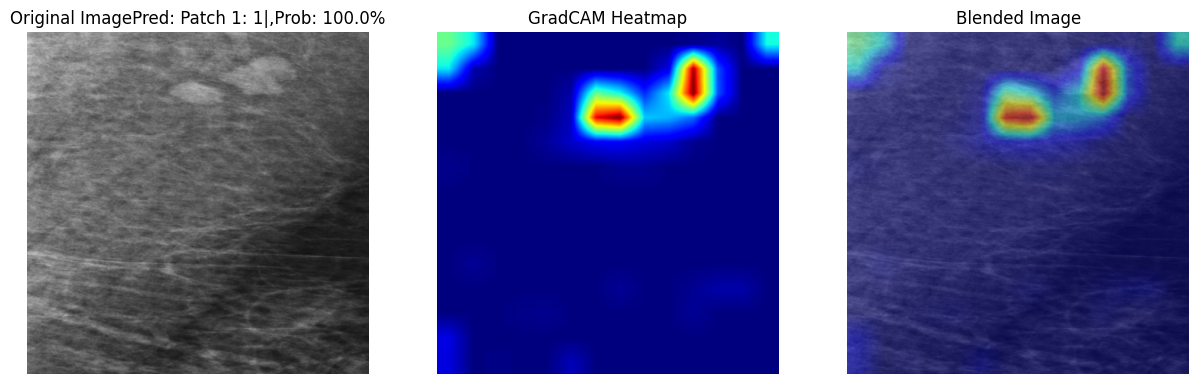


=== Patch 2/4 ===


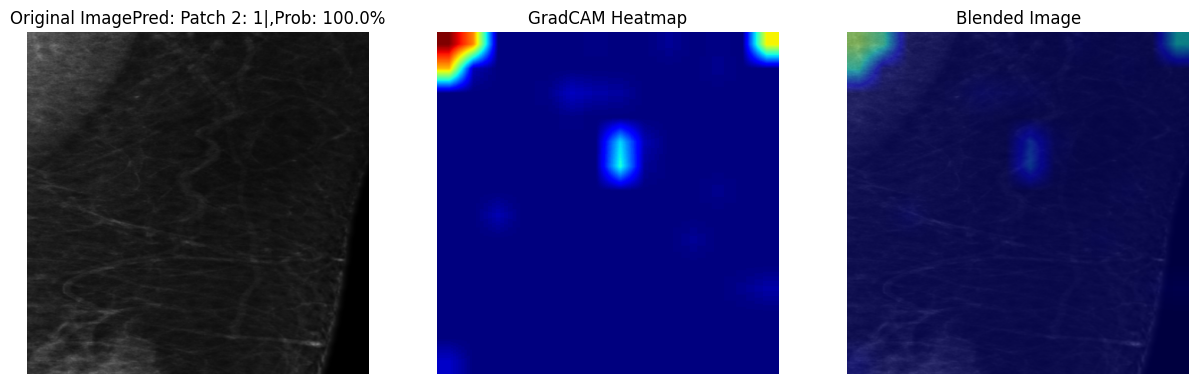


=== Patch 3/4 ===


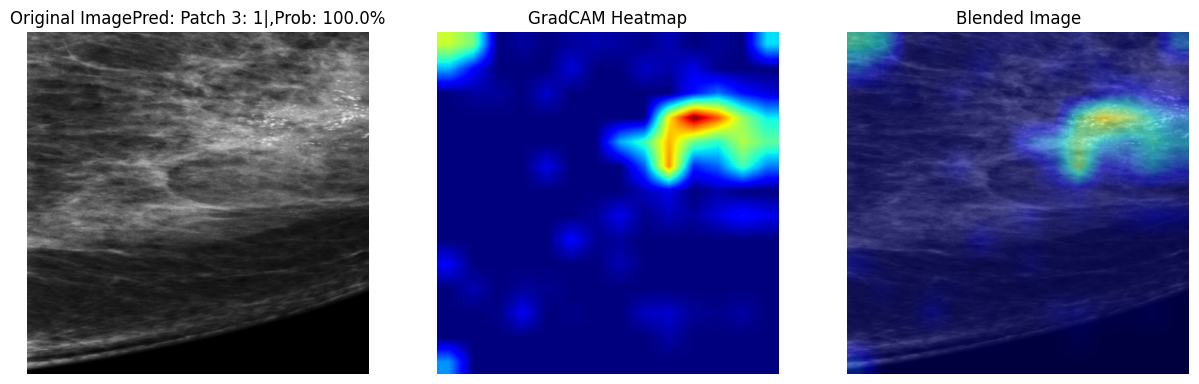


=== Patch 4/4 ===


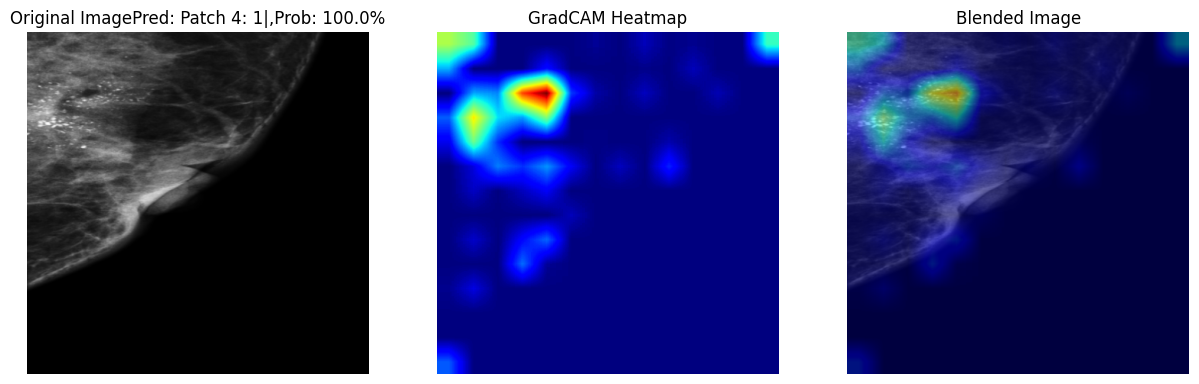

In [24]:
# Example usage
dataset_folder = './Copyof_SGM1000bbx_results/SGM1000bbx_V2/SGM1000bbx'
train_df, test_df = load_data_bbx3(dataset_folder)
pretrained_model_path = '/home/mtoan65/AI/BioMedAI/Mammo_2025_Proj/mammoSGM/SGM1000bbx_448x448_mil_v4_resnet50_p4_8212_full.pth'

model_tuple = load_full_mil_model(pretrained_model_path)

image_path = os.path.join(dataset_folder, test_df.iloc[21]['link'])
bbx_list = test_df.iloc[21]['bbx_list']
gt = test_df.iloc[21]['cancer']

model, input_tensor, img, target_layer, class_idx, pred_class, prob_class = pre_mil_gradcam(model_tuple, image_path, target_layer=None, class_idx=None)

# Debug: Print all available layers
print("Available layers in model:")
for name, module in model.named_modules():
    print(f"  {name}")

# Check if target_layer exists
print(f"\nTarget layer: {target_layer}")

gradcam_map = mil_gradcam(model, input_tensor, target_layer, class_idx)
#gradcam_map = gradcam_plus_plus(model, input_tensor, target_layer, class_idx)

# # Aggregate patch heatmaps for MIL models
# if gradcam_map.ndim == 3:
#     gradcam_map = gradcam_map.mean(axis=0).astype(np.uint8)

# post_mil_gradcam(gradcam_map, img, bbx_list=bbx_list, option=5, blend_alpha=0.5, pred=pred_class, prob=prob_class, gt_label=gt)

print(f"GradCAM shape: {gradcam_map.shape}, dtype: {gradcam_map.dtype}")

# Visualize each patch with its own GradCAM
if gradcam_map.ndim == 3:
    num_patches = gradcam_map.shape[0]
    
    # Get model metadata to split image into patches
    _, input_size, _, _, _, num_patches_meta, arch_type = model_tuple
    
    # Split original image into patches (same as in pre_mil_gradcam)
    from src.gradcam.mil_gradcam_utils import split_image_into_patches
    patch_images = split_image_into_patches(img, num_patches, input_size)
    
    print(f"\nVisualizing {num_patches} patches separately:")
    
    # Visualize each patch image with its GradCAM
    for patch_idx in range(num_patches):
        patch_cam = gradcam_map[patch_idx]  # Shape: (H, W)
        patch_img = patch_images[patch_idx]  # PIL Image of the patch
        
        print(f"\n=== Patch {patch_idx + 1}/{num_patches} ===")
        
        # Create custom pred string with patch info
        pred_str = f"Patch {patch_idx + 1}: {pred_class}"
        
        # Call post_mil_gradcam for this patch IMAGE with its heatmap
        post_mil_gradcam(
            patch_cam, 
            patch_img,  # Use patch image, not original image
            bbx_list=None,  # No bounding boxes for individual patches
            option=3,  # Option 3: Original patch | Heatmap | Blended
            blend_alpha=0.5, 
            pred=pred_str, 
            prob=prob_class, 
            gt_label=None  # Don't show GT for individual patches
        )
    
    # Also show aggregated version on full image
    # print("\n=== Aggregated Heatmap on Full Image ===")
    # gradcam_map_agg = gradcam_map.mean(axis=0).astype(np.uint8)
    # post_mil_gradcam(
    #     gradcam_map_agg, 
    #     img, 
    #     bbx_list=bbx_list, 
    #     option=1, 
    #     blend_alpha=0.5, 
    #     pred=f"Aggregated: {pred_class}", 
    #     prob=prob_class, 
    #     gt_label=gt
    # )
else:
    # Standard model - single heatmap
    post_mil_gradcam(
        gradcam_map, 
        img, 
        bbx_list=bbx_list, 
        option=5, 
        blend_alpha=0.5, 
        pred=pred_class, 
        prob=prob_class, 
        gt_label=gt
    )
